In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
import datetime

from controllers.utils import set_seeds
from controllers.base_model import BaseModelFromScratch
from controllers.base_data import DatasetEnum
from controllers.features import get_scaler
from controllers.data import Data

set_seeds(0)

/home/williamharris/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
btc_dataset = Data(lookback=10, train_size=0.6, validation_size=0.2, test_size=0.2, scaler=get_scaler(), feature_set='BTC_Data', time_to_predict=1, features=None)

--------------------- X_train ---------------------
Features: ['ATR_3', 'ATR_7', 'ATR_14', 'ATR_32', 'BB_UPPER_5', 'BB_LOWER_5', 'BB_MIDDLE_5', 'BB_UPPER_10', 'BB_LOWER_10', 'BB_MIDDLE_10', 'BB_UPPER_20', 'BB_LOWER_20', 'BB_MIDDLE_20', 'BLOCK_SIZE', 'HASH_RATE', 'DIFFICULTY', 'TRANSACTION_RATE', 'ACTIVE_ADDRESSES', 'NEW_ADDRESSES', 'ROC_3', 'ROC_6', 'ROC_12', 'ROC_24', 'RSI_3', 'RSI_7', 'RSI_14', 'RSI_32', 'WILLIAMS_3', 'WILLIAMS_7', 'WILLIAMS_14', 'WILLIAMS_32', 'MI_3', 'MI_9', 'MI_18', 'CCI_5', 'CCI_10', 'CCI_20', 'BASP_BUY_10', 'BASP_SELL_10', 'BASP_BUY_20', 'BASP_SELL_20', 'BASP_BUY_40', 'BASP_SELL_40', 'ER_5', 'ER_10', 'ER_15', 'ER_20', 'MACD_LOW', 'MACD_SIGNAL_LOW', 'MACD_MID', 'MACD_SIGNAL_MID', 'MACD_HIGH', 'MACD_SIGNAL_HIGH', 'ADX_3', 'ADX_7', 'ADX_14', 'ADX_21', 'STOCH_3', 'STOCH_7', 'STOCH_14', 'STOCH_21', 'STOCHRSI_3', 'STOCHRSI_7', 'STOCHRSI_14', 'STOCHRSI_21', 'BBWIDTH_5', 'BBWIDTH_10', 'BBWIDTH_20', 'PERCENT_B_5', 'PERCENT_B_10', 'PERCENT_B_20', 'TARGET']
start date: 201

# BTC

2022-08-21 16:42:36.134220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:42:36.140169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:42:36.140745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:42:36.141983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 16:42:36.142481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Epoch 1/20


2022-08-21 16:42:46.173980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


93/93 [==============================] - 14s 45ms/step - loss: 0.6930 - auc: 0.5101 - binary_accuracy: 0.5096 - val_loss: 0.6941 - val_auc: 0.5055 - val_binary_accuracy: 0.4895
Epoch 2/20
93/93 [==============================] - 2s 25ms/step - loss: 0.6930 - auc: 0.5090 - binary_accuracy: 0.5049 - val_loss: 0.6936 - val_auc: 0.5016 - val_binary_accuracy: 0.4946
Epoch 3/20
93/93 [==============================] - 2s 23ms/step - loss: 0.6929 - auc: 0.5117 - binary_accuracy: 0.5079 - val_loss: 0.6937 - val_auc: 0.5030 - val_binary_accuracy: 0.4943
Epoch 4/20
93/93 [==============================] - 2s 22ms/step - loss: 0.6927 - auc: 0.5160 - binary_accuracy: 0.5068 - val_loss: 0.6945 - val_auc: 0.5075 - val_binary_accuracy: 0.4900
Epoch 5/20
93/93 [==============================] - 2s 22ms/step - loss: 0.6927 - auc: 0.5151 - binary_accuracy: 0.5084 - val_loss: 0.6937 - val_auc: 0.5038 - val_binary_accuracy: 0.4941
Epoch 6/20
93/93 [==============================] - 2s 22ms/step - loss: 0.

{'log_val': 0.6946577803985028,
 'accuracy_val': 0.5002457606291472,
 'f_1': 0.22900473933649285,
 'recall': 0.14617618586640851,
 'precision': 0.5284339457567804,
 'auc': 0.5058140040665043}

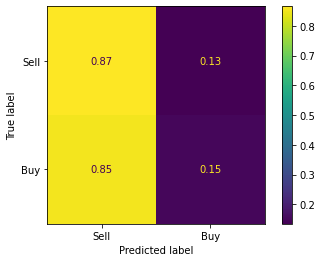

In [3]:
class Model(BaseModelFromScratch):
    def create_model(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(
            tf.keras.layers.LSTM(
                380,
                dropout=0.3, 
                return_sequences=True,
                input_shape=(self.dataset.X_train.shape[1:]),
            )
        )
        self.model.add(tf.keras.layers.LSTM(32, dropout=0.3, return_sequences=True))
        self.model.add(tf.keras.layers.LSTM(32, dropout=0.3, return_sequences=True))
        self.model.add(tf.keras.layers.LSTM(380, dropout=0.3))
        self.model.add(tf.keras.layers.Dense(32, activation="relu"))
        self.model.add(tf.keras.layers.Dropout(0.3))
        self.model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    def train_model(self):
        opt = tf.keras.optimizers.Nadam(learning_rate=0.0001)
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = tf.keras.callbacks.TensorBoard(f"{self.directory}/{self.project_name}/tb_logs/{time}")
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
        self.model.compile(
            loss="binary_crossentropy",
            optimizer=opt,
            metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()],
        )
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(self.dataset.y_train.tolist()), y=[i for x in self.dataset.y_train for i in x])
        class_weights = dict(enumerate(class_weights))

        self.model.fit(
            self.dataset.X_train,
            self.dataset.y_train,
            validation_data=(self.dataset.X_validation, self.dataset.y_validation),
            epochs=20,
            batch_size=526,
            class_weight=class_weights,
            callbacks=[tensorboard],
            shuffle=False,
        )


m = Model(model_name="btc_all_features", directory='models', project_name='testing', dataset=btc_dataset)
m.train()
m.run_statistics(DatasetEnum.Test)

In [4]:
m.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 380)           687040    
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            52864     
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_3 (LSTM)               (None, 380)               627760    
                                                                 
 dense (Dense)               (None, 32)                12192     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [5]:
m.save_model()

INFO:tensorflow:Assets written to: ram://f8d947a2-2d85-482d-8357-1ec0e13e5ef8/assets


INFO:tensorflow:Assets written to: ram://f8d947a2-2d85-482d-8357-1ec0e13e5ef8/assets


# ETH

In [6]:
eth_dataset = Data(lookback=10, train_size=0.6, validation_size=0.2, test_size=0.2, scaler=get_scaler(), feature_set='ETH_Data', time_to_predict=1, features=None)

--------------------- X_train ---------------------
Features: ['ATR_3', 'ATR_7', 'ATR_14', 'ATR_32', 'BB_UPPER_5', 'BB_LOWER_5', 'BB_MIDDLE_5', 'BB_UPPER_10', 'BB_LOWER_10', 'BB_MIDDLE_10', 'BB_UPPER_20', 'BB_LOWER_20', 'BB_MIDDLE_20', 'BLOCK_SIZE', 'HASH_RATE', 'DIFFICULTY', 'TRANSACTION_RATE', 'ACTIVE_ADDRESSES', 'NEW_ADDRESSES', 'ROC_3', 'ROC_6', 'ROC_12', 'ROC_24', 'RSI_3', 'RSI_7', 'RSI_14', 'RSI_32', 'WILLIAMS_3', 'WILLIAMS_7', 'WILLIAMS_14', 'WILLIAMS_32', 'MI_3', 'MI_9', 'MI_18', 'CCI_5', 'CCI_10', 'CCI_20', 'BASP_BUY_10', 'BASP_SELL_10', 'BASP_BUY_20', 'BASP_SELL_20', 'BASP_BUY_40', 'BASP_SELL_40', 'ER_5', 'ER_10', 'ER_15', 'ER_20', 'MACD_LOW', 'MACD_SIGNAL_LOW', 'MACD_MID', 'MACD_SIGNAL_MID', 'MACD_HIGH', 'MACD_SIGNAL_HIGH', 'ADX_3', 'ADX_7', 'ADX_14', 'ADX_21', 'STOCH_3', 'STOCH_7', 'STOCH_14', 'STOCH_21', 'STOCHRSI_3', 'STOCHRSI_7', 'STOCHRSI_14', 'STOCHRSI_21', 'BBWIDTH_5', 'BBWIDTH_10', 'BBWIDTH_20', 'PERCENT_B_5', 'PERCENT_B_10', 'PERCENT_B_20', 'TARGET']
start date: 201

Epoch 1/20
64/64 [==============================] - 8s 33ms/step - loss: 0.6931 - auc_1: 0.5140 - binary_accuracy: 0.5111 - val_loss: 0.6959 - val_auc_1: 0.5261 - val_binary_accuracy: 0.4827
Epoch 2/20
64/64 [==============================] - 1s 17ms/step - loss: 0.6929 - auc_1: 0.5138 - binary_accuracy: 0.5107 - val_loss: 0.6936 - val_auc_1: 0.5290 - val_binary_accuracy: 0.4919
Epoch 3/20
64/64 [==============================] - 1s 16ms/step - loss: 0.6925 - auc_1: 0.5226 - binary_accuracy: 0.5149 - val_loss: 0.6949 - val_auc_1: 0.5329 - val_binary_accuracy: 0.4963
Epoch 4/20
64/64 [==============================] - 1s 16ms/step - loss: 0.6921 - auc_1: 0.5256 - binary_accuracy: 0.5196 - val_loss: 0.6946 - val_auc_1: 0.5410 - val_binary_accuracy: 0.4915
Epoch 5/20
64/64 [==============================] - 1s 17ms/step - loss: 0.6917 - auc_1: 0.5297 - binary_accuracy: 0.5191 - val_loss: 0.6973 - val_auc_1: 0.5477 - val_binary_accuracy: 0.4903
Epoch 6/20
64/64 [===========================

{'log_val': 0.7180247106564668,
 'accuracy_val': 0.5215397068081662,
 'f_1': 0.36317931529806086,
 'recall': 0.27045819219112144,
 'precision': 0.5526411657559198,
 'auc': 0.5237953392897531}

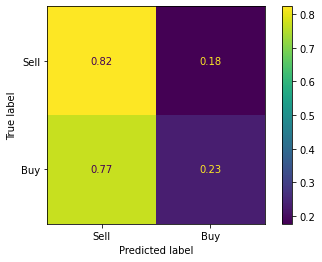

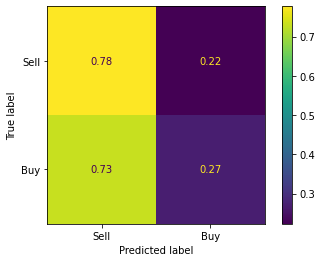

In [7]:
class Model(BaseModelFromScratch):
    def create_model(self):
        self.model = tf.keras.models.Sequential()
        self.model.add(
            tf.keras.layers.LSTM(
                128,
                dropout=0.3, 
                return_sequences=True,
                input_shape=(self.dataset.X_train.shape[1:]),
            )
        )
        self.model.add(tf.keras.layers.LSTM(64, dropout=0.3))
        self.model.add(tf.keras.layers.Dense(32, activation="relu"))
        self.model.add(tf.keras.layers.Dropout(0.3))
        self.model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    def train_model(self):
        opt = tf.keras.optimizers.Nadam()
        time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = tf.keras.callbacks.TensorBoard(f"{self.directory}/{self.project_name}/tb_logs/{time}")
        early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
        self.model.compile(
            loss="binary_crossentropy",
            optimizer=opt,
            metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()],
        )
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(self.dataset.y_train.tolist()), y=[i for x in self.dataset.y_train for i in x])
        class_weights = dict(enumerate(class_weights))

        self.model.fit(
            self.dataset.X_train,
            self.dataset.y_train,
            validation_data=(self.dataset.X_validation, self.dataset.y_validation),
            epochs=20,
            batch_size=526,
            class_weight=class_weights,
            callbacks=[tensorboard],
            shuffle=False,
        )

m = Model(model_name="eth_all_features", directory='models', project_name='testing', dataset=eth_dataset)
m.train()
m.run_statistics(DatasetEnum.Validation)
m.run_statistics(DatasetEnum.Test)

In [8]:
m.save_model()

INFO:tensorflow:Assets written to: ram://88e5c857-ed9f-417b-a3e5-0c11a78019d0/assets


INFO:tensorflow:Assets written to: ram://88e5c857-ed9f-417b-a3e5-0c11a78019d0/assets
